## Brain MRI Segmentation with Unet | TensorFlow and Keras

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from utils import *
from unet import *

2024-12-01 15:55:54.132058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 15:55:54.205057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 15:55:54.225586: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 15:55:54.350985: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 15:55:55.627930: W tensorflow/compiler/tf2

In [2]:
# Setting size parameters of images
im_width = 256
im_height = 256

## Loading the image and mask paths

In [3]:
image_filenames_train = []

# creating a list of all files containing the word 'mask'
# in Local Machine
# mask_files = glob('../../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# in Kaggle
mask_files = glob('/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training/*')

image_filenames_train = glob('/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/*')


paired_files = list(zip(sorted(image_filenames_train), sorted(mask_files)))
print(image_filenames_train[:10])
len(image_filenames_train)



['/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/0071-gt-12.jpg', '/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/0061-gt-15.jpg', '/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/0055-gt-18.jpg', '/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/0019-gt-19.jpg', '/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/0060-gt-14.jpg', '/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/0012-gt-17.jpg', '/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/0003-gt-20.jpg', '/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac_MRI_Dataset/es_training_gt/0032-gt-15.jpg', '/home/khroos/work/Unet-Brain-MRI-Segmentation-Tensorflow-Keras/Cardiac

646

## Plotting few images and masks

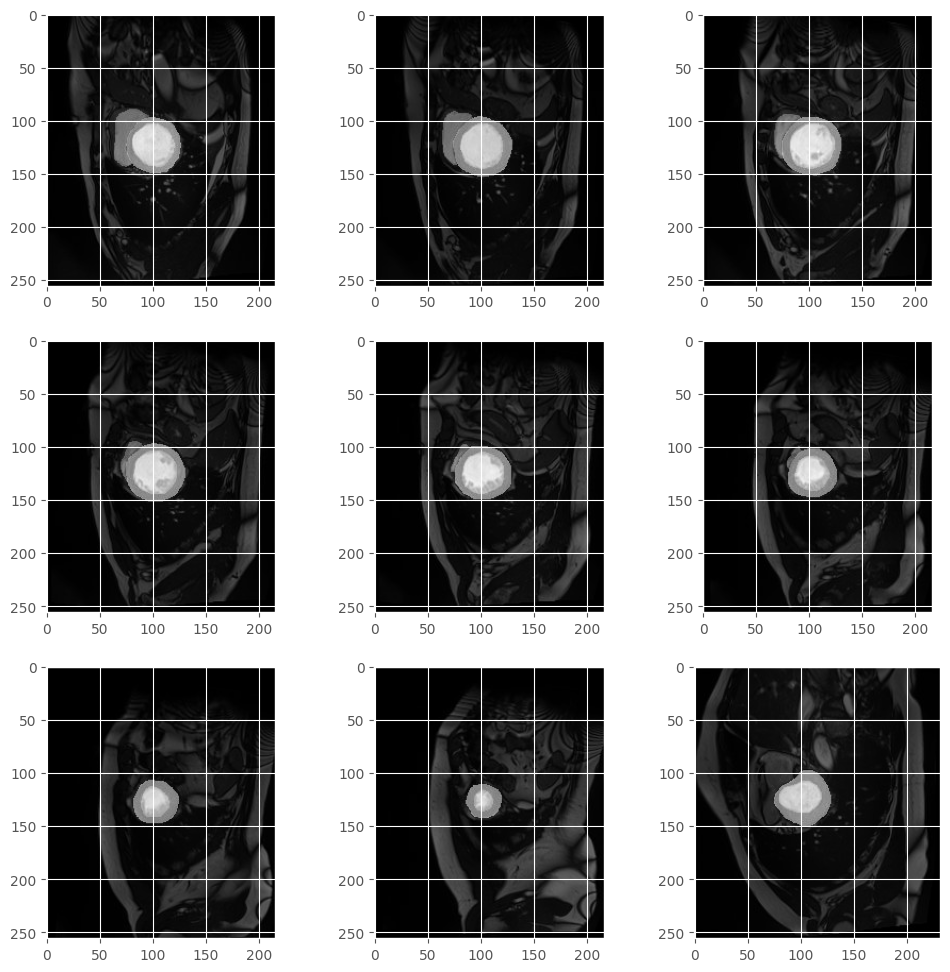

In [4]:
# Assuming you have sorted image and mask file paths
image_filenames_train = sorted(image_filenames_train)
mask_files = sorted(mask_files)

# Plot with a 3x3 grid
plot_from_img_path(3, 3, image_filenames_train, mask_files)


# **Create data frame and split data on train set, validation set and test set**

In [5]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.1)

# Further split this val and train
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)


(464, 2)
(65, 2)
(117, 2)


## **Data genertator, data augmentation and adjust data**

In [6]:
# Referring Code From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        y_col=None,  # For images, y_col is None
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        y_col=None,    # For masks, y_col is None
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [7]:
''' After mask Normalization if the value is <= 0.5 then that Mask 
will be considered a complete black one and does not have any Tumor '''
def normalize_and_diagnose(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    # Ensure mask has shape (batch_size, height, width, 1)
    if mask.ndim == 3:
        mask = np.expand_dims(mask, axis=-1)

    # Ensure data types are float32
    img = img.astype('float32')
    mask = mask.astype('float32')

    # Optional: Print shapes and types for debugging
    print("Normalized image shape:", img.shape)
    print("Normalized mask shape:", mask.shape)
    print("Image dtype:", img.dtype)
    print("Mask dtype:", mask.dtype)

    return img, mask



In [8]:
EPOCHS = 100
BATCH_SIZE = 8
learning_rate = 1e-4
smooth=100

In [9]:
model = unet()
model.summary()

I0000 00:00:1733043357.343300   53730 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733043357.480197   53730 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733043357.480376   53730 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733043357.486963   53730 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733043357.487079   53730 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,043,651 (118.42 MB)

 Trainable params: 31,037,763 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [11]:
train_generator_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_param,
                                target_size=(im_height, im_width))
    
test_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS

opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["categorical_crossentropy", iou, dice_coefficients])


history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = test_gen,
                    validation_steps=len(df_val) // BATCH_SIZE)

Found 464 validated image filenames.
Found 464 validated image filenames.


/home/khroos/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Normalized image shape: (8, 256, 256, 3)
Normalized mask shape: (8, 256, 256, 1)
Image dtype: float32
Mask dtype: float32
Normalized image shape: (8, 256, 256, 3)
Normalized mask shape: (8, 256, 256, 1)
Image dtype: float32
Mask dtype: float32
Epoch 1/100


ValueError: None values not supported.

In [ ]:
# Ensure valid inputs
if train_gen is None or test_gen is None:
    raise ValueError("train_gen or test_gen is None. Check your data generators.")
if len(df_train) == 0 or len(df_val) == 0:
    raise ValueError("df_train or df_val is empty. Check your datasets.")
if len(df_train) // BATCH_SIZE <= 0:
    raise ValueError("Invalid steps_per_epoch. Check BATCH_SIZE or df_train.")
if len(df_val) // BATCH_SIZE <= 0:
    raise ValueError("Invalid validation_steps. Check BATCH_SIZE or df_val.")

# Fit the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(df_train) // BATCH_SIZE, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    validation_data=test_gen,
    validation_steps=len(df_val) // BATCH_SIZE
)


Normalized image shape: (32, 256, 256, 3)
Normalized mask shape: (32, 256, 256, 1)
Image dtype: float32
Mask dtype: float32
Normalized image shape: (32, 256, 256, 3)
Normalized mask shape: (32, 256, 256, 1)
Image dtype: float32
Mask dtype: float32
Epoch 1/100


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficient']
test_dice_coeff_list = history_post_training['val_dice_coefficient']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()

## Load previously trained Model

In [ ]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficient_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficient': dice_coefficients  } )

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width)  )

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0] )
print('Test IoU ', results[1] )
print('Test Dice Coefficient ', results[2] )


## Plotting Predicted Masks Segmentation results from the Test Image set

In [ ]:
for i in range(20):
    index = np.random.ranint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    # print(imgs.shape) (256, 256 , 3)
    img = img[np.newaxis, :, :, : ]
    # print(img.shape) # (1, 256, 256, 3)

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()

    